Image Deconvolution (ADMM Plug-and-Play Priors w/ BM3D)
=======================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve an image deconvolution problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Set up forward operator and test signal consisting of blurred signal with
additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = random.randn(Ax.shape)
y = Ax + σ * noise

Set up ADMM solver.

In [4]:
f = loss.SquaredL2Loss(y=y, A=A)
C = linop.Identity(x_gt.shape)

λ = 20.0 / 255  # BM3D regularization strength
g = λ * functional.BM3D()

ρ = 1.0  # ADMM penalty parameter
maxiter = 10  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.T @ y,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  9.21e+00  9.643e+00  1.472e+01      3  2.084e-04


   1  1.66e+01  3.772e+00  9.269e+00      3  2.291e-04


   2  2.36e+01  1.408e+00  6.593e+00      2  6.982e-04


   3  3.01e+01  1.081e+00  4.910e+00      2  4.567e-04


   4  3.66e+01  9.279e-01  3.868e+00      2  3.328e-04


   5  4.28e+01  8.365e-01  3.186e+00      2  2.493e-04


   6  4.92e+01  7.930e-01  2.704e+00      2  1.942e-04


   7  5.56e+01  6.859e-01  2.308e+00      1  9.081e-04


   8  6.19e+01  7.066e-01  2.061e+00      1  6.495e-04


   9  6.81e+01  6.851e-01  1.856e+00      1  6.272e-04


Show the recovered image.

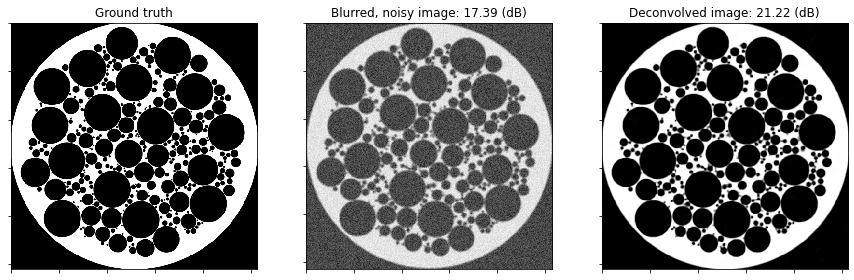

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = y[nc:-nc, nc:-nc]
yc = snp.clip(yc, 0, 1)
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

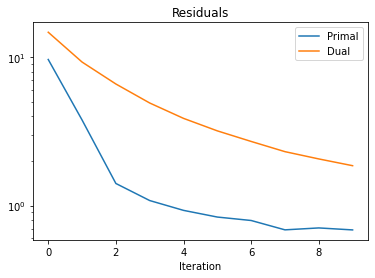

In [7]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)